In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import pickle
from glob import glob
import os
import gc
from keras.preprocessing.image import load_img

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset

from model import UNetResNet34, predict_proba
from utils import load_checkpoint
from dataset import pad_reflect, unpad_reflect, unpad_reflect256, TgsDataSet
from postprocess import rle_encode

from importlib import reload
import metrics
reload(metrics)
from metrics import *

from augmentation_huang import do_center_pad_to_factor

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

## post-process

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#device = torch.device("cpu")
#torch.set_num_threads(20)

img_size_target = 101#128,256

SEED = 6789#5678#4567#3456#2345#1234

In [5]:
# choose best threshold using validset
with open('../data/processed/dataset_%d.pkl'%SEED, 'rb') as f:
    ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = pickle.load(f)

## select best_threshold for iou using valid dataset

In [6]:
# valid data & its flipped version
val_ds = TgsDataSet(x_valid, y_valid, transform=False)
val_dl = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

## x.shape = [1, 128, 128]
val_ds_flip = TgsDataSet(np.array([x[:,:,::-1] for x in x_valid]), y_valid, transform=False)
val_dl_flip = DataLoader(
    val_ds_flip,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

In [7]:
# load the trained model
net = UNetResNet34(pretrained=True).cuda(device=device)
checkpoint_path = 'checkpoint/1008_v1_seed6789_snapshot/cycle4.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

In [8]:
net.set_mode('valid')
preds_valid = (predict_proba(net, val_dl, device) + \
              np.array([x[:,::-1] for x in predict_proba(net, val_dl_flip, device)])) / 2

In [9]:
y_valid.shape, preds_valid.shape

((400, 1, 101, 101), (400, 256, 256))

In [10]:
# keep only nonzero mask images
preds_valid = preds_valid[y_valid.reshape(400, 101*101).sum(axis=1)!=0, :, :]
y_valid = y_valid[y_valid.reshape(400, 101*101).sum(axis=1)!=0, :, :, :]


[0.82254098 0.82663934 0.82663934 0.82827869 0.83032787 0.83237705
 0.83278689 0.83278689 0.83360656 0.83442623 0.83442623 0.83442623
 0.83442623 0.83401639 0.83114754 0.82991803 0.82991803 0.82827869
 0.82827869 0.82868852 0.825      0.82377049 0.82254098 0.82295082
 0.8204918  0.82008197 0.81680328 0.81393443 0.80901639 0.80368852
 0.79508197]


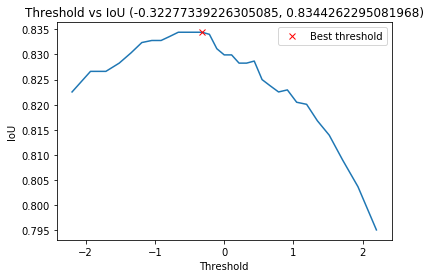

In [11]:
thresholds_ori = np.linspace(0.1, 0.9, 31)#np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori))

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)

#y_valid = np.array([do_center_pad_to_factor(image.reshape(101, 101), factor=32).reshape(1, 128, 128) \
#                    for image in y_valid]) #if use Huang's augmentation, otherwise comment this line
preds_valid = np.array([unpad_reflect256(image) for image in preds_valid])
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [12]:
threshold_best, iou_best

(-0.32277339226305085, 0.8344262295081968)

## using best threshold to predict

In [13]:
## create testset
img_ids = [f.split('/')[-1].split('.')[0] for f in glob('../data/raw/test_images/images/*.png')]

x_test = [(np.array(load_img("../data/raw/test_images/images/{}.png".format(idx), \
                                      color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(img_ids)]

In [81]:
# with open('../data/processed/testset%d.pkl'%SEED, 'wb') as f:
#     pickle.dump([img_ids, x_test], f)

In [14]:
# for testset, also predict raw & flipped version, then average
#x_test_arr = np.array(list(map(pad_reflect, x_test)))
x_test_arr = np.array(x_test).reshape(18000, 1, 101, 101) #if use Huang's augmentation, otherwise comment this line
y_test = np.zeros(shape=(18000, 1, 101, 101))

test_ds = TgsDataSet(x_test_arr, y_test, transform=False)
test_dl = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

test_ds_flip = TgsDataSet(np.array([x[:,:,::-1] for x in x_test_arr]), y_test, transform=False)
test_dl_flip = DataLoader(
    test_ds_flip,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

In [15]:
%%time

#preds_test = predict_proba(net, test_dl, device)

net.set_mode('test')
preds_test = (predict_proba(net, test_dl, device) + \
              np.array([x[:,::-1] for x in predict_proba(net, test_dl_flip, device)])) / 2

CPU times: user 2h 7min 13s, sys: 1h 29min 55s, total: 3h 37min 8s
Wall time: 16min 18s


In [16]:
# saving
with open('prediction/1008_v1_seed6789_snapshot_cycle4.pkl', 'wb') as f:
    pickle.dump([preds_test, threshold_best], f, protocol=4)

In [5]:
# # loading
seed = 1234

with open('prediction/1006_v1_1234.pkl', 'rb') as f:
    preds_test, threshold_best = pickle.load(f)

In [19]:
## pred_prob to preds by threashold_best, and unpad to 101x101
unpad_pred_dict = {idx: np.round(unpad_reflect256(preds_test[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(img_ids))}


In [20]:
# load saved predicted zero image ids, and remove small masks (<25)
# with open('../data/processed/zero_nonzero_img_ids.pkl', 'rb') as f:
#     zero_img_ids, nonzero_img_ids = pickle.load(f)

df = pd.read_csv('../submissions/013_0929_pytorch_pred_zero_mask.csv.gz')
zero_mask_ids = df.loc[df.rle_mask.notna(), 'id'].tolist()
print('another model predict zero mask in testset cnt: ', len(zero_mask_ids))

for k,v in unpad_pred_dict.items():
    if k in zero_mask_ids:#remove zero mask predictions
        v = v * 0
        unpad_pred_dict[k] = v
    else:
        continue

another model predict zero mask in testset cnt:  7886


In [52]:
# # predict zero, nonzero imgs
# zero_img_ids, nonzero_img_ids = [], []

# for k,v in unpad_pred_dict.items():
#     if v.sum()<25:
#         zero_img_ids.append(k)
#     else:
#         nonzero_img_ids.append(k)

# with open('../data/processed/zero_nonzero_img_ids.pkl', 'wb') as f:
#     pickle.dump(zero_mask_ids, f)

In [45]:
# cnt = 0
# for k,v in unpad_pred_dict.items():
#     if 0<v.sum()<25:
#         #print(k)
#         cnt += 1
# print(cnt)

# for k,v in unpad_pred_dict.items():
#     if v.sum()<25:
#         v *= 0
#         v[0, 0] = 1
#         unpad_pred_dict[k] = v
#     else:
#         v *= 0
#         unpad_pred_dict[k] = v

In [43]:
print('pred zero mask: ', 7848, 7848/18000)

pred zero mask:  7848 0.436


In [21]:
## for single model submission
pred_dict = {idx: rle_encode(pred) for idx, pred in tqdm_notebook(unpad_pred_dict.items())}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub = sub.reset_index().rename(columns={'index':'id', 0:'rle_mask'})

In [23]:
#print(sub_name)
sub.to_csv('../submissions/1006_v1_seed%d.csv.gz'%SEED, compression='gzip', index=False)

## blending models

- snapshot 6 cycles

In [4]:
from importlib import reload
import postprocess
reload(postprocess)
from postprocess import smooth_mask

In [20]:
## TODO: for 5-fold-cv models, blend probability preds here (Note each model has specific threshold_best)

In [4]:
## create testset
img_ids = [f.split('/')[-1].split('.')[0] for f in glob('../data/raw/test_images/images/*.png')]

x_test = [(np.array(load_img("../data/raw/test_images/images/{}.png".format(idx), \
                                      color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(img_ids)]

In [ ]:
# unpad_pred_dicts = []

# for i in [0,1,2,3,4,5]:
#     with open('prediction/1008_v1_seed1234_snapshot_cycle%d.pkl'%i, 'rb') as f:
#         preds_test, threshold_best = pickle.load(f)
#     unpad_pred_dict = {idx: np.round(unpad_reflect256(preds_test[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(img_ids))}
#     unpad_pred_dicts.append(unpad_pred_dict)
#     del unpad_pred_dict
#     del preds_test
#     gc.collect()

# for i in [0,1,2,3,4,5]:
#     with open('prediction/1008_v1_seed2345_snapshot_cycle%d.pkl'%i, 'rb') as f:
#         preds_test, threshold_best = pickle.load(f)
#     unpad_pred_dict = {idx: np.round(unpad_reflect256(preds_test[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(img_ids))}
#     unpad_pred_dicts.append(unpad_pred_dict)
#     del unpad_pred_dict
#     del preds_test
#     gc.collect()

# unpad_pred_dict = {}
# for img_id in img_ids:
#     unpad_pred_dict[img_id] = np.round(unpad_pred_dicts[0][img_id] + \
#                                        unpad_pred_dicts[1][img_id] + \
#                                        unpad_pred_dicts[2][img_id] + \
#                                        unpad_pred_dicts[3][img_id] + \
#                                        unpad_pred_dicts[4][img_id] + \
#                                        unpad_pred_dicts[5][img_id] + \
#                                        unpad_pred_dicts[6][img_id] + \
#                                        unpad_pred_dicts[7][img_id] + \
#                                        unpad_pred_dicts[8][img_id] + \
#                                        unpad_pred_dicts[9][img_id] + \
#                                        unpad_pred_dicts[10][img_id] + \
#                                        unpad_pred_dicts[11][img_id] \
#                                        > 6)

In [5]:
# 合并N个fold的预测（0-1），用户voting方式blending
preds_test_blend = None

for seed in [1234, 2345, 3456, 4567, 5678, 6789]:
    for i in [0,1,2,3,4,5]:
        with open('prediction/1008_v1_seed%d_snapshot_cycle%d.pkl'%(seed, i), 'rb') as f:
            preds_test, threshold_best = pickle.load(f)
        preds_test = np.array([np.round(unpad_reflect256(_preds_test) > threshold_best) \
                               for _preds_test in tqdm_notebook(preds_test)])
        if preds_test_blend is None:
            preds_test_blend = preds_test
        else:
            preds_test_blend += preds_test
        del preds_test
        gc.collect()

In [14]:
# save 18 models' blending preds
# saving
# with open('prediction/1008_v1_seed_snapshot_cycle_blending_1_2_3_4_5_6.pkl', 'wb') as f:
#     pickle.dump(preds_test_blend, f, protocol=4)

# loading
with open('prediction/1008_v1_seed_snapshot_cycle_blending_1_2_3_4_5_6.pkl', 'rb') as f:
    preds_test_blend = pickle.load(f)

In [15]:
N = 18#15#9

unpad_pred_dict = {}
for i, img_id in enumerate(img_ids):
    _pred = np.round(preds_test_blend[i] > N)
    
    # add new idea: smooth serrated edges. can tune kernel_size: 5,6,7...
    #_pred = smooth_mask(_pred, kernel_size=5)
    
    unpad_pred_dict[img_id] = _pred

In [7]:
# img_id = 'dce0abc347'
# (unpad_pred_dicts[4][img_id] == unpad_pred_dict[img_id]).mean()

In [16]:
## update last day: postprocessing
with open('../data/processed/postprocess_vertical20.pkl', 'rb') as f:
    mod_output_all = pickle.load(f)
print('modify %d images: ', len(mod_output_all.keys()))

for k,v in mod_output_all.items():
    if k in img_ids:
        unpad_pred_dict[k] = v

modify %d images:  219


In [17]:
# all image model predict zero mask imgs
# '../submissions/1010_849model_all_mask_predict_zero_mask_seed1234_2345_3456_blend.csv.gz' gives the best LB
df = pd.read_csv('../submissions/1010_849model_all_mask_predict_zero_mask_seed1234_2345_3456_4567_5678_blend.csv.gz')
#zero_mask_ids = df.loc[df.rle_mask.notna(), 'id'].tolist()
zero_mask_ids = df.loc[df.is_zero_mask==True, 'id'].tolist()

print('model predict zero mask in testset cnt: ', len(zero_mask_ids))
for k,v in unpad_pred_dict.items():
    if k in zero_mask_ids:#remove zero mask predictions
        v = v * 0
        unpad_pred_dict[k] = v
    else:
        continue

model predict zero mask in testset cnt:  7428


In [18]:
## for single model submission
pred_dict = {idx: rle_encode(pred) for idx, pred in tqdm_notebook(unpad_pred_dict.items())}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub = sub.reset_index().rename(columns={'index':'id', 0:'rle_mask'})

In [19]:
sub.to_csv('../submissions/1010_v1_seed1234_2345_3456_4567_5678_6789_predict_zero_img_seed1234_2345_3456_4567_5678_postprocess_v3.csv.gz', compression='gzip', index=False)

In [20]:
df0 = pd.read_csv('../submissions/1010_v1_seed1234_2345_3456_4567_5678_6789_predict_zero_img_seed1234_2345_3456_4567_5678_postprocess_v3.csv.gz')
df1 = pd.read_csv('../submissions/869_1010_v1_seed1234_2345_3456_4567_5678_6789_predict_zero_img_seed1234_2345_3456_4567_5678.csv.gz')


In [21]:
# excluding zero-mask images, modifying 100 test masks
(df0.loc[df0.rle_mask.notnull(), 'rle_mask']!=df1.loc[df1.rle_mask.notnull(), 'rle_mask']).sum()

152